In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import json
import scipy
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc,  classification_report
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras import regularizers
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')
pd.set_option('display.width', 500)
pd.set_option('max_columns', 60)

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
engage=pd.read_csv('takehome_user_engagement.csv')

In [3]:
users=pd.read_csv('takehome_users.csv', encoding='latin1')

In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [10]:
users['object_id'].nunique()==len(users)

True

In [29]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [13]:
engage.tail()

,time_stamp,user_id,visited
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1
207916,2014-01-26 08:57:12,12000,1


In [6]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
engage['visited'].value_counts()

1    207917
Name: visited, dtype: int64

In [11]:
# Merge the two data sets to use the time stamp of each user logins
merged=users.merge(engage, how='inner', left_on='object_id', right_on='user_id')

In [12]:
merged.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,user_id,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,2014-04-22 03:53:30,1,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-15 03:45:04,2,1
2,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-11-29 03:45:04,2,1
3,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-09 03:45:04,2,1
4,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2013-12-25 03:45:04,2,1


In [16]:
# Now we need to convert the time_stamp into datetime object
merged['time_stamp']=pd.to_datetime(merged['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [24]:
merged['time_stamp'][0]-merged['time_stamp'][1]

Timedelta('158 days 00:08:26')

In [27]:
merged.sort_values('time_stamp', inplace=True)

In [28]:
merged.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,user_id,visited
178140,10012,2012-05-31 08:20:06,Spikes Danille,DanilleJSpikes@hotmail.com,ORG_INVITE,1.338452e+09,0,1,225,7104.0,2012-05-31 08:20:06,10012,1
59486,3428,2012-05-31 15:47:36,Spears Arthur,ArthurJSpears@gmail.com,SIGNUP_GOOGLE_AUTH,1.352822e+09,1,0,166,NaN,2012-05-31 15:47:36,3428,1
175638,9899,2012-05-31 17:19:37,Jørgensen Sofie,SofieNJrgensen@yahoo.com,ORG_INVITE,1.338485e+09,0,0,138,9899.0,2012-05-31 17:19:37,9899,1
26821,1693,2012-05-31 21:58:33,Faulkner Hayden,HaydenFaulkner@gmail.com,SIGNUP_GOOGLE_AUTH,1.399932e+09,0,1,50,NaN,2012-05-31 21:58:33,1693,1
109716,6102,2012-06-01 00:17:30,Morrison Natasha,NatashaMorrison@gustr.com,ORG_INVITE,1.339719e+09,0,0,34,6102.0,2012-06-01 00:17:30,6102,1


In [17]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 13 columns):
object_id                     207917 non-null int64
creation_time                 207917 non-null object
name                          207917 non-null object
email                         207917 non-null object
creation_source               207917 non-null object
last_session_creation_time    207917 non-null float64
opted_in_to_mailing_list      207917 non-null int64
enabled_for_marketing_drip    207917 non-null int64
org_id                        207917 non-null int64
invited_by_user_id            116887 non-null float64
time_stamp                    207917 non-null datetime64[ns]
user_id                       207917 non-null int64
visited                       207917 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(4)
memory usage: 22.2+ MB


In [30]:
users=users['object_id'].tolist()

In [83]:
# Write a function to see if a user is an adopted user
def check_user(users):
    # Looping through each user and all its login times to check if there are three different logins in a 7 day period
    adopted_users={}
    for user in users:
        logins=merged[merged['user_id']==user]['time_stamp'].tolist()
        if len(logins)<3:
            adopted_users[user]=False
        else:
            for idx, login in enumerate(logins):
                if idx<len(logins)-2:
                    latest_login=logins[idx+2]
                    difference=latest_login-login
                    if difference.days<=7 and login.date!=logins[idx+1].date and logins[idx+1].date!=latest_login.date:
                        adopted_users[user]=True
                        break
                else:
                    adopted_users[user]=False
    return(adopted_users)

In [84]:
adopted_users=check_user(users)

In [86]:
merged['Adopted']=merged['user_id'].map(adopted_users)

In [87]:
merged['Adopted'].value_counts()

True     198327
False      9590
Name: Adopted, dtype: int64

In [88]:
merged.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,user_id,visited,Adopted
178140,10012,2012-05-31 08:20:06,Spikes Danille,DanilleJSpikes@hotmail.com,ORG_INVITE,1.338452e+09,0,1,225,7104.0,2012-05-31 08:20:06,10012,1,False
59486,3428,2012-05-31 15:47:36,Spears Arthur,ArthurJSpears@gmail.com,SIGNUP_GOOGLE_AUTH,1.352822e+09,1,0,166,NaN,2012-05-31 15:47:36,3428,1,True
175638,9899,2012-05-31 17:19:37,Jørgensen Sofie,SofieNJrgensen@yahoo.com,ORG_INVITE,1.338485e+09,0,0,138,9899.0,2012-05-31 17:19:37,9899,1,False
26821,1693,2012-05-31 21:58:33,Faulkner Hayden,HaydenFaulkner@gmail.com,SIGNUP_GOOGLE_AUTH,1.399932e+09,0,1,50,NaN,2012-05-31 21:58:33,1693,1,True
109716,6102,2012-06-01 00:17:30,Morrison Natasha,NatashaMorrison@gustr.com,ORG_INVITE,1.339719e+09,0,0,34,6102.0,2012-06-01 00:17:30,6102,1,False


In [89]:
merged.reset_index(drop=True, inplace=True)

In [90]:
merged.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,user_id,visited,Adopted
0,10012,2012-05-31 08:20:06,Spikes Danille,DanilleJSpikes@hotmail.com,ORG_INVITE,1.338452e+09,0,1,225,7104.0,2012-05-31 08:20:06,10012,1,False
1,3428,2012-05-31 15:47:36,Spears Arthur,ArthurJSpears@gmail.com,SIGNUP_GOOGLE_AUTH,1.352822e+09,1,0,166,NaN,2012-05-31 15:47:36,3428,1,True
2,9899,2012-05-31 17:19:37,Jørgensen Sofie,SofieNJrgensen@yahoo.com,ORG_INVITE,1.338485e+09,0,0,138,9899.0,2012-05-31 17:19:37,9899,1,False
3,1693,2012-05-31 21:58:33,Faulkner Hayden,HaydenFaulkner@gmail.com,SIGNUP_GOOGLE_AUTH,1.399932e+09,0,1,50,NaN,2012-05-31 21:58:33,1693,1,True
4,6102,2012-06-01 00:17:30,Morrison Natasha,NatashaMorrison@gustr.com,ORG_INVITE,1.339719e+09,0,0,34,6102.0,2012-06-01 00:17:30,6102,1,False


The features that could have an impact on user adoption could be: <br>
'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip'<br>
I will do some plotting to see if there are any effects by these factors.

In [110]:
# Let's take a look at the phone types
sources=merged.groupby('creation_source')['Adopted'].value_counts().unstack(level=0)

In [111]:
sources

creation_source,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
Adopted,,,,,
False,1780,3499,825,2024,1462
True,45016,66592,18397,35521,32801


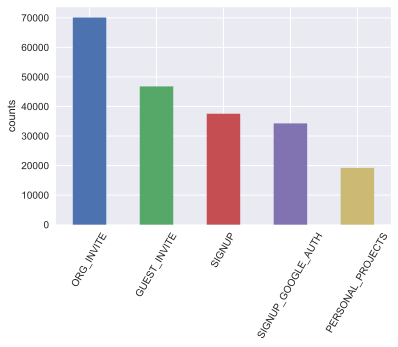

In [136]:
# How many sources are there?
merged['creation_source'].value_counts().plot.bar()
plt.xticks(rotation=60)
plt.ylabel('counts')
plt.show()

In [124]:
sources_perc=sources/sources.sum(axis=0)

In [125]:
sources_perc

creation_source,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
Adopted,,,,,
False,0.038037,0.049921,0.04292,0.053909,0.04267
True,0.961963,0.950079,0.95708,0.946091,0.95733


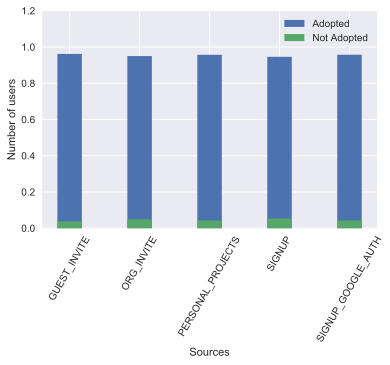

In [128]:
# See the adopted users in each source
N=5
ind=np.arange(N)
p1=plt.bar(ind, sources_perc.iloc[1,:], width=0.35)
p2=plt.bar(ind, sources_perc.iloc[0,:], width=0.35)
plt.xticks(ind, sources.columns.tolist())
plt.legend((p1[0], p2[0]), ('Adopted', 'Not Adopted'))
plt.ylabel('Number of users')
plt.xlabel('Sources')
plt.xticks(rotation=60)
plt.ylim((0, 1.2))
plt.show()

There are no differences in any source.

In [129]:
# Let's take a look at the phone types
mailing_list=merged.groupby('opted_in_to_mailing_list')['Adopted'].value_counts().unstack(level=0)

In [131]:
mailing_list.columns=['Not on mailing list', 'On mailing list']

In [132]:
mailing_list

,Not on mailing list,On mailing list
Adopted,,
False,7197,2393
True,147049,51278


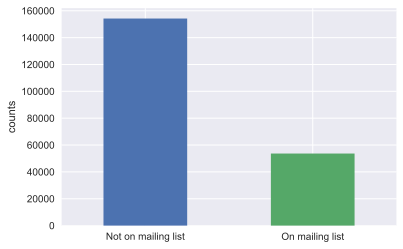

In [137]:
# How many sources are there?
merged['opted_in_to_mailing_list'].value_counts().plot.bar()
plt.xticks(range(2), ['Not on mailing list', 'On mailing list'],rotation=0)
plt.ylabel('counts')
plt.show()

In [138]:
mailing_perc=mailing_list/mailing_list.sum(axis=0)

In [139]:
mailing_perc

,Not on mailing list,On mailing list
Adopted,,
False,0.046659,0.044586
True,0.953341,0.955414


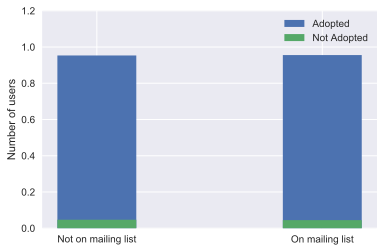

In [140]:
# See the adopted users in each source
N=2
ind=np.arange(N)
p1=plt.bar(ind, mailing_perc.iloc[1,:], width=0.35)
p2=plt.bar(ind, mailing_perc.iloc[0,:], width=0.35)
plt.xticks(ind, mailing_list.columns.tolist())
plt.legend((p1[0], p2[0]), ('Adopted', 'Not Adopted'))
plt.ylabel('Number of users')
plt.ylim((0, 1.2))
plt.show()

Again, no didderences.

In [141]:
# Let's take a look at the phone types
marketing_drip=merged.groupby('enabled_for_marketing_drip')['Adopted'].value_counts().unstack(level=0)

In [143]:
marketing_drip.columns=['No marketing drip', 'Has marketing drip']

In [144]:
marketing_drip

,No marketing drip,Has marketing drip
Adopted,,
False,8142,1448
True,167645,30682


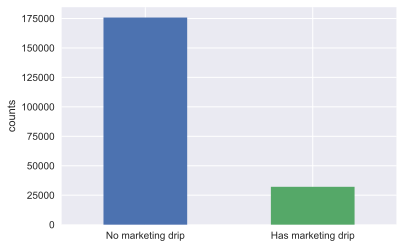

In [146]:
# How many sources are there?
merged['enabled_for_marketing_drip'].value_counts().plot.bar()
plt.xticks(range(2), ['No marketing drip', 'Has marketing drip'],rotation=0)
plt.ylabel('counts')
plt.show()

In [147]:
marketing_perc=marketing_drip/marketing_drip.sum(axis=0)

In [148]:
marketing_perc

,No marketing drip,Has marketing drip
Adopted,,
False,0.046317,0.045067
True,0.953683,0.954933


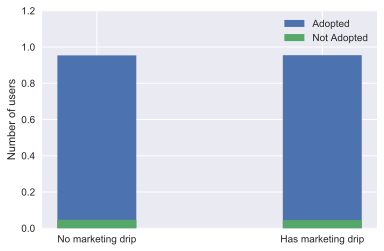

In [149]:
# See the adopted users in each source
N=2
ind=np.arange(N)
p1=plt.bar(ind, marketing_perc.iloc[1,:], width=0.35)
p2=plt.bar(ind, marketing_perc.iloc[0,:], width=0.35)
plt.xticks(ind, marketing_drip.columns.tolist())
plt.legend((p1[0], p2[0]), ('Adopted', 'Not Adopted'))
plt.ylabel('Number of users')
plt.ylim((0, 1.2))
plt.show()

I don't see any differences.

1      2298
13     2098
62     2072
4      2064
2      1967
7      1922
3      1868
225    1579
16     1524
161    1491
8      1461
31     1457
218    1447
235    1445
117    1441
78     1397
0      1390
108    1369
44     1361
160    1327
106    1312
107    1303
63     1254
139    1252
35     1246
343    1243
74     1204
64     1181
370    1177
10     1170
       ... 
367      39
244      38
228      36
111      32
338      30
308      30
143      29
362      28
397      27
349      26
410      23
279      23
394      22
242      22
299      21
374      20
237      17
307      16
348      16
346      16
386      15
151      14
310      11
329      10
365      10
396       9
183       8
412       8
355       7
416       2
Name: org_id, Length: 417, dtype: int64

The 3 factors I have investigated didn't give any predictive power as there are no differences among them. Further data may be needed to make predictions including (but not limited to):<br>
<b>activities per week</b><br>
<b>device used</b><br>
<b>average length per login</b><br>
If we can gather more data, we may be able to get some features that can be used to predict adopted users.